# Calibrating the number of iterations ($i_{\max}$) to run GRASP

In [76]:
import pandas as pd
from grasp_iters import read_results

names = [
    "rat783_522_261_0_p20_a2", # 0
    "rat783_522_261_0_p20_a3",
    "rl1323_882_441_0_p20_a2", # 2
    "rl1323_882_441_0_p20_a3",
    "anpcp_882_441_0_p20_a2",  # 4
    "anpcp_882_441_0_p20_a3",
]
name = names[5]

iters = read_results(name)

iters

,iter,beta,RGD_OF,AFVS_OF,time,is_new_best
0,0,0.795654,8025,4239,5.961818,True
1,1,0.867107,6803,4338,10.882905,False
2,2,0.800370,6163,4185,16.610197,True
3,3,0.188034,5413,4871,17.967098,False
4,4,0.866803,8129,4318,23.320361,False
...,...,...,...,...,...,...
4995,4995,0.855868,6959,4209,22258.566378,False
4996,4996,0.764274,6872,4388,22260.629341,False
4997,4997,0.529342,7116,4128,22266.790669,False
4998,4998,0.587886,6894,4176,22272.009903,False


In [77]:
iters["time"].diff().mean()

4.45541987361474

In [78]:
def get_improvs(iters_df: pd.DataFrame):
    improvs = iters_df[iters_df["is_new_best"] == True].drop("is_new_best", axis=1)

    # multiplication is negative because the problem is a minimization problem,
    # a decrease in the objective function (a negative percent change) means a better solution
    percents = improvs["AFVS_OF"].pct_change().mul(-100)
    improvs.insert(loc=4, column="imp", value=percents)

    # iterations without improvement (iwi)
    iter_diffs = improvs["iter"].diff().fillna(0).astype(int)
    improvs.insert(loc=6, column="iwi", value=iter_diffs)

    return improvs

In [79]:
improvs = get_improvs(iters)
improvs

,iter,beta,RGD_OF,AFVS_OF,imp,time,iwi
0,0,0.795654,8025,4239,NaN,5.961818,0
2,2,0.800370,6163,4185,1.273885,16.610197,2
11,11,0.258486,5876,4112,1.744325,48.043793,9
14,14,0.139898,5454,4003,2.650778,62.732671,3
61,61,0.472395,5816,3985,0.449663,290.428416,47


In [80]:
from utils import format_latex_table

format_latex_table(improvs, f"nb_results\\grasp\\iters_improvs_{name}.tex");

c:\Users\netoo\local-personal\repos\alpha-neighbor-p-center-problem\anpcp\utils.py:104: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dataframe.to_latex(path, float_format="%.2f", multirow=True)


In [81]:
import matplotlib.pyplot as plt

def plot_improvs(
    iters_df: pd.DataFrame,
    lastimprov: int,
    annotation_xdiff: int,
    annotation_ydiff: int,
    color: str = "blue",
    filename: str = ""
):
    fig, ax = plt.subplots(figsize=(20, 5), dpi=150)
    
    ax.plot(
        iters_df["iter"][:lastimprov],
        iters_df["AFVS_OF"].cummin()[:lastimprov],
        color=color,
    )

    for _, row in improvs.iterrows():
        of = int(row["AFVS_OF"])
        i = int(row["iter"])
        percent = row["imp"]

        ax.annotate(
            f"x(S) = {of}",
            (i, of),
            xytext=(i + annotation_xdiff, of + annotation_ydiff),
        )

    ax.set_title(f"Improvements in $S$ during GRASP")
    ax.set_ylabel("$x(S)$")
    ax.set_xlabel("Iteration")

    if filename:
        fig.savefig(filename, bbox_inches="tight")
    else:
        plt.show()

Manually adjust parameters to plot each instance

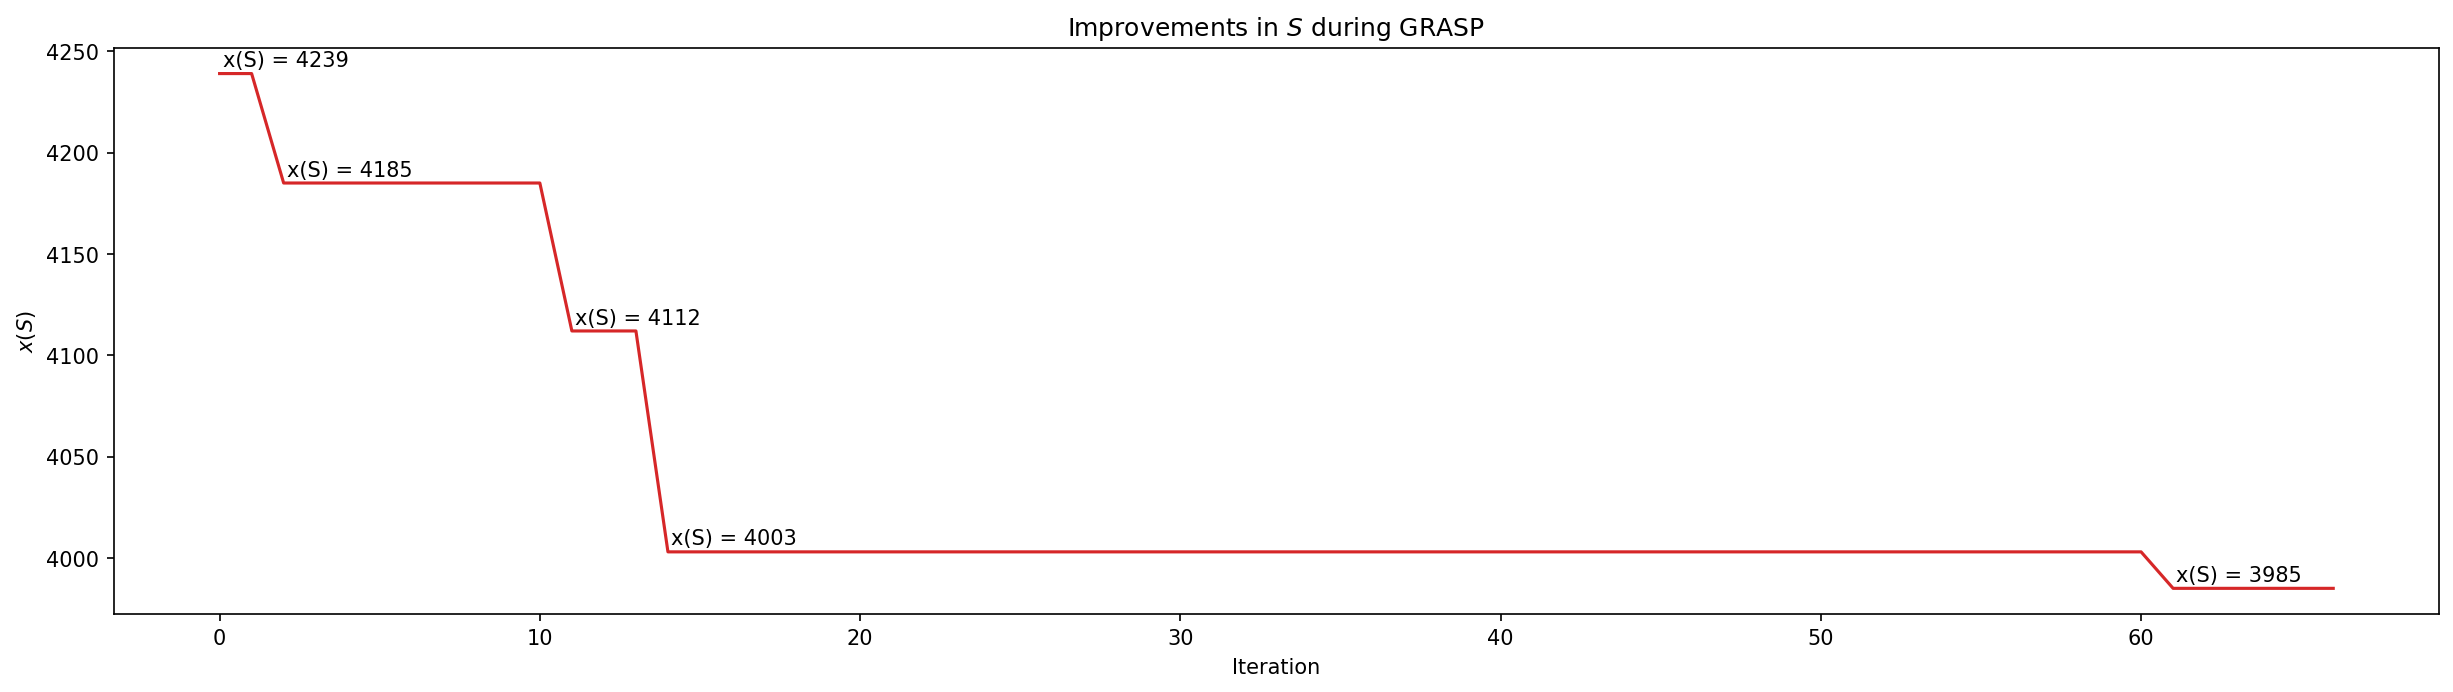

In [93]:
plot_improvs(
    iters, 67, 0.1, 3.5,
    "tab:blue" if name.endswith("2") else "tab:red",
    f"nb_results\\grasp\\iters_plot_{name}.png"
)